# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [1]:
import datetime as dt
import glob
import itertools
import json
import os
import dill
import pickle
import random
import re
import sys
import time
from string import punctuation
import locale
"en_US.UTF-8"
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import janitor
import janitor.ml
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport
pd.options.mode.chained_assignment = None

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
medical = pd.read_csv("../data/insurance2.csv")

In [5]:
medical.shape

(1338, 8)

In [6]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [7]:
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   int64  
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   int64  
 5   region          1338 non-null   int64  
 6   charges         1338 non-null   float64
 7   insuranceclaim  1338 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


<div class="alert alert-block alert-success">
<b></b></div>

__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__

<AxesSubplot:xlabel='charges', ylabel='Count'>

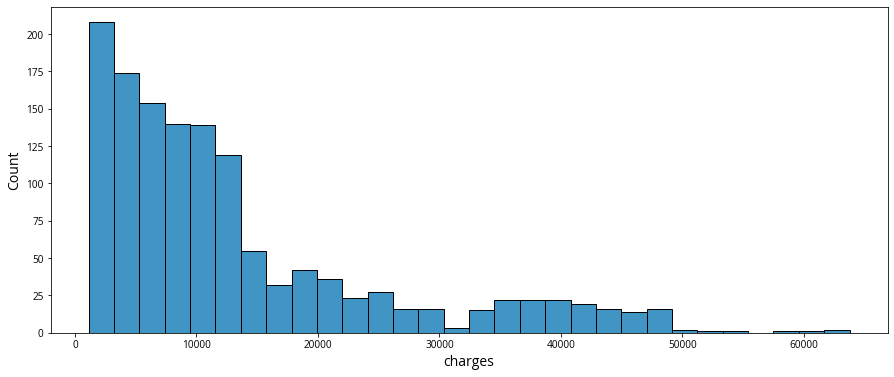

In [8]:
sns.histplot(x="charges", data=medical)

In [9]:
print(f"Mean charges: {medical.charges.mean():0.2f} +/- {medical.charges.std():0.2f}")

Mean charges: 13270.42 +/- 12110.01


<div class="alert alert-block alert-success">
<b></b></div>

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__ We rarely, if ever, know true population parameters; we have to estimate them from a sample. This means we can calculate the mean of the sample as our best estimate of the population mean and the standard deviation as our best estimate of the population standard deviation. Above, we highlighted one result from the CLT, whereby the sampling distribution (of the mean) becomes narrower and narrower with the square root of the sample size. We remind ourselves that another result from the CLT is that even if the underlying population distribution is not normal, the sampling distribution will tend to become normal with sufficiently large sample size (remember the "> 30 samples" rule of thumb?). Well, if the underlying distribution is heavily skewed then you'd want to increase your sample size... for example by having 1,338 samples as in this example. We can solve this problem using bootstrap resampling. We will use the **MEAN** as our test statistic.

<div class="alert alert-block alert-success">
<b></b></div>

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__ The answers you will find online are, sadly, incomplete and do not draw on the wealth of stats knowledge you've built. Remember the DataCamp course on stats and the bootstrapping intro? Use that know how.

**Helper functions...**

In [10]:
def draw_bs_reps(data, func, size=None):
    """Draw bootstrap replicates."""

    # Initialize array of replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, len(data)))
    return bs_replicates

In [11]:
# set some useful constants
SEED = 42
N_BOOTS = 50
N_REPLICATES = 10000
ADMIN_GUESS = 12000

# set random seed
np.random.seed(SEED)

# store the sample data
charges_data = medical.charges

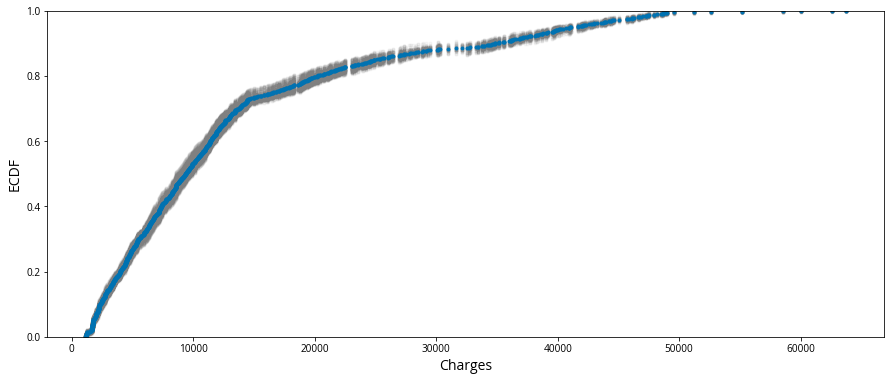

In [12]:
# iterate over the number of bootstrap resamplings you want
for _ in range(N_BOOTS):
    
    # Generate bootstrap sample
    bs_sample = np.random.choice(charges_data, size=len(charges_data))

    # Compute and plot ECDF from bootstrap sample
    sns.ecdfplot(bs_sample, marker=".", linestyle="none", color='gray', alpha=0.05)

# Compute and plot ECDF from original data
sns.ecdfplot(charges_data, marker=".", linestyle="none")
plt.xlabel("Charges");
plt.ylabel("ECDF");

Mean = 13267.57522930508
95% confidence interval = [12626.3542349 13928.905857 ]


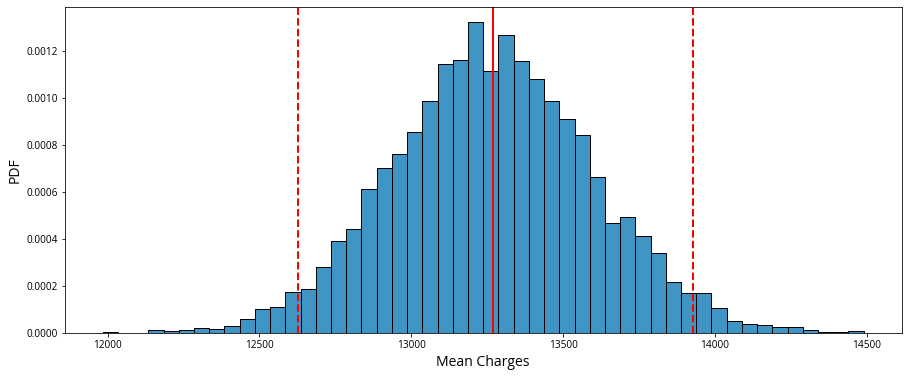

In [13]:
# Draw bootstrap replicates of the mean
bs_replicates = draw_bs_reps(charges_data, np.mean, N_REPLICATES)

# Compute the 95% confidence interval: conf_int
bs_mean = np.mean(bs_replicates)
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the mean and confidence interval
print(f"Mean = {bs_mean}")
print(f"95% confidence interval = {conf_int}")

# Plot the histogram of the replicates
sns.histplot(bs_replicates, bins=50, stat="density")
plt.axvline(bs_mean, color="r", linewidth=2);
for c in conf_int:
    plt.axvline(c, color="r", linewidth=2, linestyle="dashed");
plt.xlabel("Mean Charges");
plt.ylabel("PDF");

It does not appear that the admin needs to be worried that the average charges have fallen to \\$12K. But, let's assume that were true, let's test the probabilty of that happening given our sample of charges.

To set up the bootstrap hypothesis test, we reuse the mean as our test statistic. Remember, our goal is to calculate the probability of getting a mean charge greater than or equal to what was observed for our sample if the hypothesis that the true mean of charges is equal to that of the admin's guess is true. First,  we will translate all of the sample data such that the mean is \\$12K. This involves adding \\$12K and subtracting the mean our sample from each measurement. This leaves other properties of the original distribution, such as the variance, unchanged.

Translated mean: 11999.999999999996
Probability of observing sampled mean: 0.0002


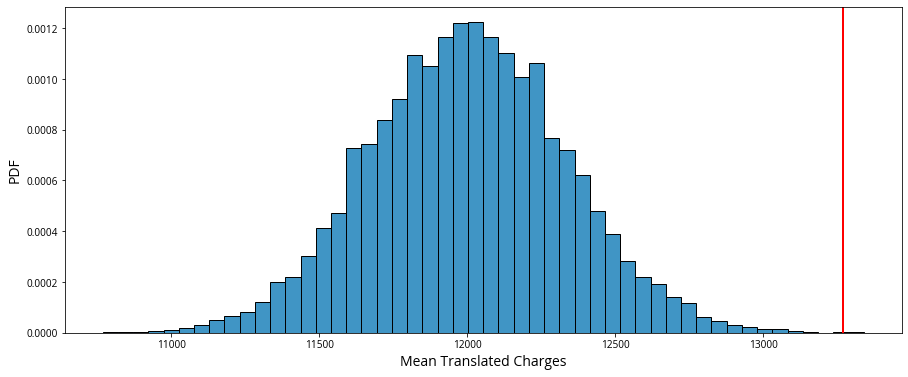

In [14]:
# A one-sample bootstrap hypothesis test

# Make an array of translated impact forces: translated_force_b
translated_charges = charges_data - np.mean(charges_data) + ADMIN_GUESS
print(f"Translated mean: {np.mean(translated_charges)}")

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_charges, np.mean, N_REPLICATES)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates >= np.mean(charges_data)) / N_REPLICATES

# Print the p-value
print(f"Probability of observing sampled mean: {p}")

# Plot the histogram of the replicates
sns.histplot(bs_replicates, bins=50, stat="density")
plt.axvline(np.mean(charges_data), color="r", linewidth=2);
plt.xlabel("Mean Translated Charges");
plt.ylabel("PDF");

The low p-value suggests that the null hypothesis that our observed medical charges come from a population with mean \\$12K is rejected.

<div class="alert alert-block alert-success">
<b></b></div>

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__

* Null hypothesis: insured and uninsured people have the same mean charges.
* Alternate hypothesis: any one of an infinite possibilities that are not the null :)

With T-tests, there are several assumptions:

> Given two groups (1, 2), this test is only applicable when:
> 
> 1. the two sample sizes (that is, the number n of participants of each group) are equal;
> 2. **it can be assumed that the two distributions have the same variance;**

<https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_sample_sizes_and_variance>

<div class="alert alert-block alert-success">
<b></b></div>

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [15]:
insured = medical[medical.insuranceclaim == 1]
uninsured = medical[~medical.insuranceclaim == 1]

<AxesSubplot:xlabel='charges', ylabel='Count'>

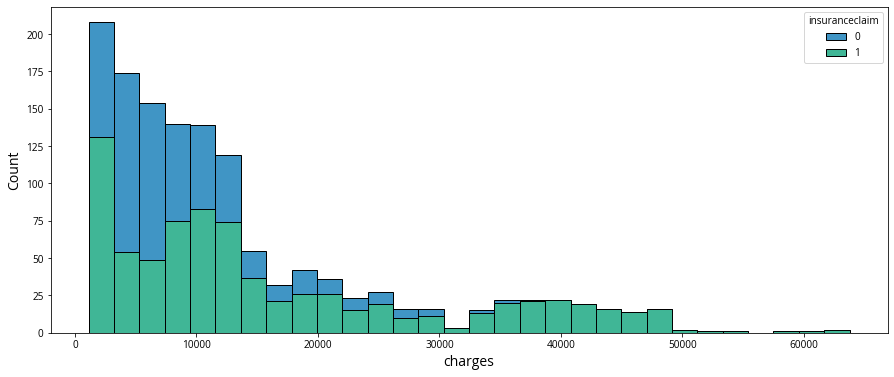

In [24]:
sns.histplot(x="charges", hue="insuranceclaim", data=medical, multiple="stack")

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test